# Numerical simulation for upper bound on dynamic blocksize expansion

Isthmus - Sept 2018

Organization:
-  Abstract
-  Background reading
-  Adversary model
-  Threat model
-  Mitigation strategies
-  Numeric simulations
-  Observations
-  FAQ

## Abstract:
The current bound on expansion of the Monero block(/chain) is that a block cannot be larger than the median size of the previous 100 blocks. Given the 2-minute block time, this means that the protocol has a 3-hour memory, which performs well for most use cases. However, it is prudent to consider edge cases as well - the current absence of medium or long-term memory leaves the network susceptible to block size inflation from a well-funded adversary. This notebook quantifies the scale of damage and costs of a worst-case-scenario attack, and suggests some starting points for developing mitigation strategies.

## Background Reading:
-  Jolly Mort's [Monero Dynamic Block Size and Dynamic Minimum Fee](https://github.com/JollyMort/monero-research/blob/master/Monero%20Dynamic%20Block%20Size%20and%20Dynamic%20Minimum%20Fee/Monero%20Dynamic%20Block%20Size%20and%20Dynamic%20Minimum%20Fee%20-%20DRAFT.md)
-  ArticMine's [BitcoinTalk discussion](https://bitcointalk.org/index.php?topic=753252.msg13591241#msg13591241) about oversize block attacks.

The topic of blockchain bloat has been discussed in many communities for many years. This notebook is not the first mention of the idea, it simply seeks to model the threat in the context of Monero's protocol.

## Adversary model:
A well-funded (€€,€€€+) adversary wishes to disrupt the Monero cryptocurrency/network/community. The adversary could be a crypto whale with a trading position against Monero, a 3-letter agency that decides breaking Monero is easier than cracking it, powers that benefit from the incumbent financial/economic systems, or even a careless Monero trader who wishes to sow chaos and reap cheap coins.

## Threat model:
The attacker creates a set of transactions whose:
-  Net fee > coinbase
-  Net size ~ 2*median(last 100 blocks)

The attacker does not need to mine; they only need to create sets of transactions that other (honest) miners are incentivized to mine.

Monero's dynamic blocksize includes a coinbase penalty function to incentivize miners to properly manage block size; the attacker overrides these economic safeguards by including a net fee greater than the coinbase. Given all of the possible subsets of transactions in the memory pool (and taking into account the coinbase penalty), the attacker's transactions must be the most profitable combination, and combine to continuously push the maximum size of the block.

**Result: The *block size* doubles every 3 hours, indefinitely. The *blockchain size* doubles in less than a day and grows catastrophically large.**

## Mitigation strategies:
This notebook contains the first iteration of two crude mitigation approaches:
-  **Two-point short/long-term memory**: Same as the current method, but adds a 1-week memory to our current 3-hour memory
-  **Span (multi-timescale) memory**: Generalization of the two-point memory.

**The mitigation strategies prototyped here are certainly NOT perfect!! The parameters have not been tuned, the edge cases have not been explored, and computational/memory resources have not been taken into account. Please iterate and improve on these rough draft notions, or replace them with better ones. :- )**

## Simulations

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Set parameters

General state information about simulation and cost estimation

In [2]:
# Simulation parameters
initial_blocksize = 100 # kB
num_blocks_simulate = 10000 # about 2 weeks
current_blockchain_size_GB = 65 # GB

# Economic parameters
cost_of_1_XMR = 55 # EUR
current_reward = 4 # XMR

Set the timescale and growth bound for two-point short/long term memory. The short-term memory uses the current implementation; with `long_term_max_growth = 4` and `long_term_memory = 600` the long-term memory allows the block size to quadruple every day (which is a very generous overestimate, especially for sustained growth).

In [3]:
# For 2-point short/long-term memory
long_term_max_growth = 4 # quadruple
long_term_memory = 600 # on order of 1 day 

Set the number of (exponentially-distributed) time scales to be used in the span multi-timescale memory model. For example, `index_offset = 7` and `index_set_size = 6` checks the growth in the last $2^7$ blocks, last $2^8$ blocks, ..., last $2^{13}$ blocks.

In [4]:
# For span memory (multi-timescale)
index_offset = 7
index_set_size = 6

### Initialize simulation

In [5]:
# Initialize with lowball estimate that last 100 blocks were 100 kB in size
pre_length = max(100, long_term_memory, 2**(7+index_set_size))

height_vector = list(range(-pre_length,num_blocks_simulate)) 
block_sizes = (pre_length+num_blocks_simulate)*[initial_blocksize] # For regular model
block_sizes_long = (pre_length+num_blocks_simulate)*[initial_blocksize] # For 2 point memory
block_sizes_long_span = (pre_length+num_blocks_simulate)*[initial_blocksize] # For span memory

### Run simulation
Simulation loops over heights, and models three possible boundings:
-  Short term memory only (current implementation)
-  Two-point short/long-term memory
-  Span memory, a generalization to more than 2 points/timescales

In [6]:
for attack_block_num in range(pre_length, pre_length + num_blocks_simulate):
        
    # Model short-term memory (current method)
    last_blocks = block_sizes[(attack_block_num-100):attack_block_num]
    median_prev = np.median(last_blocks)
    next_size = 2*median_prev
    block_sizes[attack_block_num] = next_size
    
    # Model two-point short/long-term memory
    last_blocks_long = block_sizes_long[(attack_block_num-long_term_memory):attack_block_num]
    median_prev_long = np.median(last_blocks_long)
    next_size_long = min(next_size, long_term_max_growth*median_prev_long)
    block_sizes_long[attack_block_num] = next_size_long  
    
    # Model span multi-timescale memory
    size_list = index_set_size*[np.inf]
    c = 0
    for k in range(index_offset, index_offset + index_set_size):
        this_memory_len = 2**k
        last_blocks_long_span = block_sizes_long_span[(attack_block_num-this_memory_len):attack_block_num]
        median_prev_long_span = np.median(last_blocks_long_span) 
        this_B = (2+c/index_set_size)*median_prev_long_span
        size_list[c] = this_B
        c = c + 1
        
    block_sizes_long_span[attack_block_num] = min(size_list)

## Plot results

### Block size increase

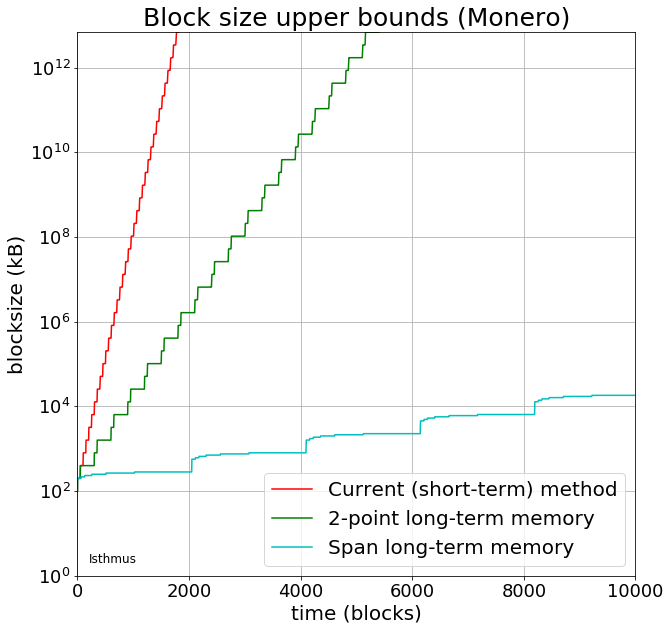

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(height_vector, block_sizes,'r', label='Current (short-term) method')
plt.plot(height_vector, block_sizes_long,'g', label='2-point long-term memory')
plt.plot(height_vector, block_sizes_long_span,'c', label='Span long-term memory')
plt.set_yscale = 'log'
plt.xlabel('time (blocks)', fontsize='20')
plt.ylabel('blocksize (kB)',  fontsize='20')
plt.title('Block size upper bounds (Monero)',  fontsize='25')
plt.grid(True)
ax.legend(loc='best', fontsize='20')
ax.set_xlim(0, num_blocks_simulate)
ax.set_yscale('log')
ax.set_ylim(1,block_sizes[num_blocks_simulate])
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.text(200, 2, 'Isthmus', fontsize=12)
plt.show()

### Blockchain size bloat

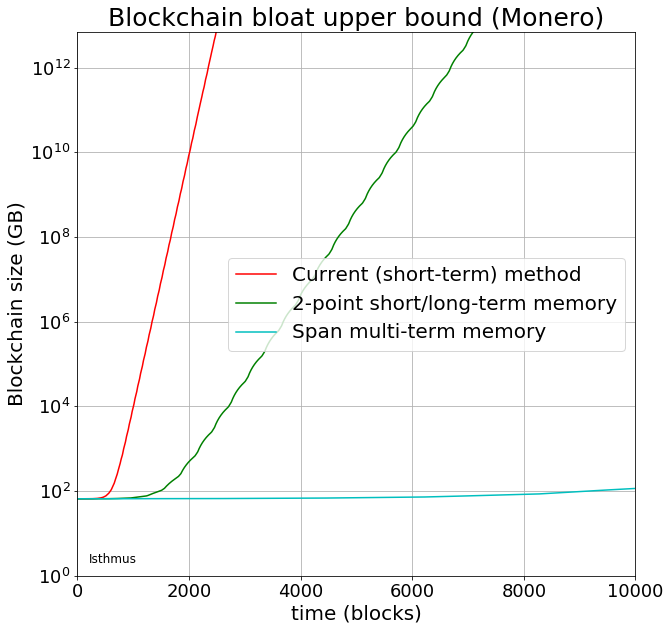

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(height_vector, current_blockchain_size_GB + np.cumsum(block_sizes)/1e6,'r', label='Current (short-term) method')
plt.plot(height_vector, current_blockchain_size_GB + np.cumsum(block_sizes_long)/1e6,'g', label='2-point short/long-term memory')
plt.plot(height_vector, current_blockchain_size_GB + np.cumsum(block_sizes_long_span)/1e6,'c', label='Span multi-term memory')
plt.set_yscale = 'log'
plt.xlabel('time (blocks)', fontsize='20')
plt.ylabel('Blockchain size (GB)',  fontsize='20')
plt.title('Blockchain bloat upper bound (Monero)',  fontsize='25')
plt.grid(True)
ax.legend(loc='best', fontsize='20')
ax.set_xlim(0, num_blocks_simulate)
ax.set_yscale('log')
ax.set_ylim(1,block_sizes[num_blocks_simulate])
plt.text(200, 2, 'Isthmus', fontsize=12)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()


## Cost analysis (GB bloat per €)

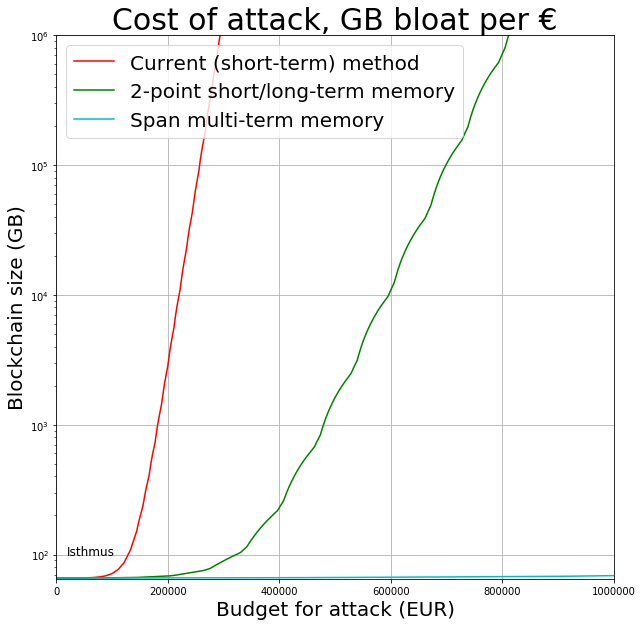

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cost_vector = [h*(cost_of_1_XMR*current_reward) for h in height_vector]
cum_curr_GB =  current_blockchain_size_GB + np.cumsum(block_sizes)/1e6;
plt.plot(cost_vector, current_blockchain_size_GB + np.cumsum(block_sizes)/1e6,'r', label='Current (short-term) method')
plt.plot(cost_vector, current_blockchain_size_GB + np.cumsum(block_sizes_long)/1e6, 'g', label='2-point short/long-term memory')
plt.plot(cost_vector, current_blockchain_size_GB + np.cumsum(block_sizes_long_span)/1e6,'c', label='Span multi-term memory')
plt.xlabel('Budget for attack (EUR)', fontsize='20')
plt.ylabel('Blockchain size (GB)',  fontsize='20')
plt.set_yscale = 'log'
plt.title('Cost of attack, GB bloat per €',  fontsize='30')
plt.grid(True)
ax.legend(loc='best', fontsize='20')
ax.set_xlim(1, 1e6)
ax.set_ylim(65,1e6)
ax.set_yscale('log')
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.text(20000, 100, 'Isthmus', fontsize=12)
plt.show()

### Check out some key times, sizes, costs
This is a bunch of verbose text output, if desired. Commented out

In [10]:
skip_me = 1

if skip_me < 1:
    time_dict = {30: '1st hour', 9*30:'9th hour', 18*30:'18th hour', 24*30:'1st day', 36*30:'35th hour', 2*24*30:'2nd day', 7*24*30:'1st week'}
    for time_in_blocks in time_dict:
        print('\n' + 25*'*')
        print('At the end of the ' + time_dict[time_in_blocks] + ':')
        print('-')
        print('# Current algorithm')
        print('Blocksize = ' + str(block_sizes[pre_length + time_in_blocks]) + ' kB')
        print('>>> Blockchain size = ' + str(current_blockchain_size_GB + sum(block_sizes[pre_length:(pre_length + time_in_blocks)])/1e6) + ' GB')
        print('-')
        print('# Two-point short/long-term algorithm')
        print('Blocksize = ' + str(block_sizes_long[pre_length + time_in_blocks]) + ' kB')
        print('Blockchain size = ' + str(current_blockchain_size_GB + sum(block_sizes_long[pre_length:(pre_length + time_in_blocks)])/1e6) + ' GB')
        print('-')
        print('# Two-point short/long-term algorithm')
        print('Blocksize = ' + str(block_sizes_long_span[pre_length + time_in_blocks]) + ' kB')
        print('Blockchain size = ' + str(current_blockchain_size_GB + sum(block_sizes_long_span[pre_length:(pre_length + time_in_blocks)])/1e6) + ' GB')
        print('-')
        print('Cost to attacker ~ ' + str(cost_of_1_XMR*current_reward*time_in_blocks) + ' EUR')

## Observations

For just over 200k EUR, an attacker can blast the Monero blocksize to 10 TB in less than 2 days. If the attack started Friday evening, almost all full nodes would be knocked off the network before Monday morning. See [The Ethereum-blockchain size has exceeded 1TB, and yes, it’s an issue](https://hackernoon.com/the-ethereum-blockchain-size-has-exceeded-1tb-and-yes-its-an-issue-2b650b5f4f62) for more discussion of this topic.

## FAQ

Q: Won't miners voluntarily avoid mining large blocks?

A1: The timescale of this attack can be mind-bogglingly FAST! In 36 hours, the blockchain explodes to 30 TB. To stop an in-progress attack, it would be necessary to modify major mining and pool software, and roll out updates across the ecosystem and dozens of platforms. The permanent damage would be on the order of tens of terabytes, even if every Monero engineer mobilized instantly with deft DevOps ability. I don't know if every random botnet operator is going to be following Reddit 24/7 and race to fix their mining pools in the middle of the night.

A2: Voluntarily avoiding large blocks means voluntarily mining blocks with less profit. Some people are greedy.

A3: Cryptocurrencies are designed to be resistant to block censorship, so any ideas to have the nodes or users reject large blocks will run into a lot of practical issues.

--- 
Q: Isn't this expensive? Won't the attacker have to keep buying Monero on the open market at full price?

A: That depends on your perspective. Major intelligence agencies have budgets on the order of tens of billions of euros. Crypto OG whales are worth millions. 200,000 EUR to tank the network by a 5 TB blockchain is a very small financial hurdle. 

The current ratio of (exchange rate):(block reward) makes this relatively inexpensive. An effectively-executed attack would not require more than 48 hours, so the attacker could just stock up on moneroj in advance. Additionally, the price will probably drop by more than an order of magnitude if nodes are choking on every block, so restocking wouldn't be particularly expensive.

--- 
Q: Isn't this more expensive than a 51% attack?

A1: A 51% is a totally different threat/consequence model. The blockchain big bang knocks nodes off the network, leaves permanent scars in the blockchain, and wreaks obvious major havoc in everybody's face with severe service disruptions. In contrast, a 51% attack on Monero is totally unnoticable to the rest of the ecosystem, causing no disruption to Monero's services, network, or community. 

A2: While the two attacks may cost the same *on paper*, there is a big logistical difference. Converting 200,000 EUR into purchasing half of the mining equipment / hashrate in the world is a huge endeavor. Converting 200,000 EUR into a blockchain big bang spam attack requires a few hours of coding open source software, and a laptop.

---
Q: We need a dynamic blocksize! What about an influx of legitimate transactions?

A: Nobody is trying to take your dynamic blocksizes away from you. Protocol can be designed to allow short-term flexibility without having to allow unbounded extremes.

If somebody can articulate a feasible use case where Monero's legitimate transaction volume sustains an increase by 4 orders of magnitude within a given day, then I will concede that we do not need an upper bound. Said use case must also include an explanation of how nodes and miners across the globe will all upgrade their equipment to handle an increase in 4 orders of magnitude in a day. (Temporary high fees are better than a permanantly-broken network).

---
Q: What happens if we implement an upper bound, and nobody ever tries this attack?

A: That's an ideal outcome! In systems handling large amounts of money, it's better to be safe than sorry - properly implementing safeguards are always better than leaving any feature or process unbounded and up to fate. 

--- 
Q: How can we possibly adjust the blocksize algorithm?

A: The current block size algorithm was designed by mere mortals, and should be subject to improvement just like every other aspect of the cryptocurrency. Belief that the first iteration of any system is perfect tends to be limiting, and often dangerous if it preserves vulnerabilities. 

---
Q: Isn't this a pretty big decision?

A: **YES, absolutely**. The discussion and development of mitigation strategies must include many different facets of the community - software engineers, economists, researchers, modelers, designers of the current algorithm, etc. This is a big undertaking that must be done deliberately. Each different strategy (or lack of one!) entails different consequences, and we must work together to make sure the community's solution does not introduce other issues / edge cases with financial incentives around mining, fees, etc. 

We should avoid both non-action and careless action.

---
Q: Have you thought about XXX mitigation strategy?

A: Not yet, so please share your ideas with us in Noncesense Research Lab ([website](https://noncesense-research-lab.github.io/), [IRC](https://www.irccloud.com/invite?channel=%23noncesense-research-lab&hostname=chat.freenode.net&port=6697&ssl=1)) or the Monero Research Lab ([website](https://www.getmonero.org/resources/research-lab/), [IRC](https://www.irccloud.com/invite?channel=%23monero-research-lab&hostname=chat.freenode.net&port=6697&ssl=1))

---
Q: What about XXX fact that renders this notebook a moot point?

A: Oh thank goodness, that's great news. Please share! Honestly, I'm hoping that there are some bloat attack safeguards in place, which are secure in a fees > coinbase situation that overrides the miner penalty mechanism. It is ideal if this notebook is in vain.